In [160]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import SVD
from collections import defaultdict
sns.set()

In [161]:
!ls *.csv

credits_clean.csv
keywords_clean.csv
links_clean.csv
metadata_clean.csv


In [162]:
ratings = pd.read_csv(r'the-movies-dataset\ratings_small.csv')
meta = pd.read_csv('metadata_clean.csv')
meta['id'] = meta.id.astype(int)
#merged = pd.merge(ratings, meta, left_on = 'movieId', right_on='id')
#merged = merged[['userId', 'movieId', 'rating', 'title']]

In [163]:
# loading the data and specifying the train and test set
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader = reader)

train = data.build_full_trainset()
test = train.build_anti_testset()

In [164]:
# using the cross validation to get a sense of optimum factor to minimize the RMSE
factor = range(1, 30)
scores = []
for f in factor:
    model = SVD(n_factors=f)
    score_cv = cross_validate(model, data, measures=['rmse'], cv=5)
    score = score_cv['test_rmse'].mean()
    scores.append(score)

Text(0, 0.5, 'RMSE')

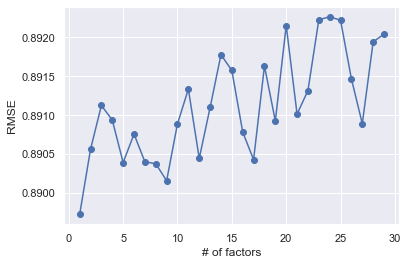

In [165]:
plt.plot(factor, scores, marker='o')
plt.xlabel('# of factors')
plt.ylabel('RMSE')

In [170]:
# using grid search to choose the best number of factors
params = {'n_factors':[5, 7, 8, 9, 12, 17]}
gs = GridSearchCV(SVD, param_grid=params, measures=['rmse'])

In [171]:
gs.fit(data)

In [172]:
# best number of factors based on grid search method
gs.best_params

{'rmse': {'n_factors': 7}}

In [173]:
gs.best_score

{'rmse': 0.8903350668870551}

In [174]:
model = SVD(n_factors = 7)
model.fit(train)

In [175]:
pred = model.test(test)

In [176]:
def top_recomm(pred_dict, predictions, userid, ratings_df, meta_data, n_top = 10 ):
    '''using the predicted values on the data, the function 
       returns the n_top predicted ratings for the specific user,
       and also the n_top rated movies for the user
    '''
    
    pred_dict = defaultdict(list)
    for user, movieid, rate, est, _ in pred:
        pred_dict[user].append((movieid, est))
    
    for user, items in pred_dict.items():
        items.sort(key = lambda x:x[1], reverse=True)
        pred_dict[user] = items[:n_top]    
    
        
    movies, rate_est = zip(*pred_dict[userid])
    suggest_df = pd.DataFrame({'movieId':movies, 'ratings':rate_est})
    suggest_df = pd.merge(meta_data, suggest_df, how='right', left_on = 'id', right_on = 'movieId')[['movieId', 'title','ratings']]
    suggest_df.sort_values(by='ratings', inplace=True)
    
    hist_df = ratings_df[ratings_df['userId']==userid]
    hist_df.sort_values(by='rating', ascending=False, inplace=True)
    hist_df = hist_df[:n_top]
    hist_df = pd.merge(meta_data, hist_df, how='right', left_on = 'id', right_on = 'movieId')[['movieId', 'title','rating']]
    hist_df.sort_values(by='rating', ascending=False, inplace=True)
    
    return suggest_df, hist_df
        
    
    

In [177]:
# predicting the ratings for the users
sugg, hist = top_recomm(pred_dict, pred, 10, ratings, meta, n_top=10)

C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [178]:
# top predicted ratings for the user
sugg

,movieId,title,ratings
9,1172,NaN,4.447425
2,1945,Nell,4.447919
3,2064,While You Were Sleeping,4.453991
8,3462,NaN,4.456609
7,1221,NaN,4.460085
6,1217,NaN,4.473518
0,905,Pandora's Box,4.486238
4,926,Galaxy Quest,4.491484
5,969,NaN,4.499432
1,858,Sleepless in Seattle,4.553156


In [179]:
# top ratings given by the user
hist

,movieId,title,rating
1,1719,The Soft Skin,5.0
2,2926,The Three Musketeers,5.0
3,1358,A Brief History of Time,5.0
4,1923,Twin Peaks: Fire Walk with Me,5.0
5,1611,The Miracle of Bern,5.0
6,50,NaN,5.0
7,2826,NaN,5.0
8,2571,NaN,5.0
9,2344,NaN,5.0
0,3019,Dr. Jekyll and Mr. Hyde,4.0
